# RESEARCH QUESTION 4

## Predicting Video Game Hit

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from pandas import Series
from math import ceil

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm

In [60]:
sales_df = pd.read_csv("../data/prep/500.csv")
temp_df1 = sales_df
temp_df1 = temp_df1.copy()
sales_df[:5]

,name,developer,rank,platform,release_date,publisher,na_sales,eu_sales,jp_sales,other_sales,...,meta_critic_count,meta_user_score,meta_user_count,meta_esrb,meta_genre,meta_multiplayer,meta_full_url,release_year,is_series,Matched_Name
0,Grand Theft Auto V,Rockstar North,4,PS3,2013-09-17,Rockstar Games,6370000,9850000,990000,3120000,...,50.0,8.3,4354,M,Modern,yes,https://www.metacritic.com/game/playstation-3/...,2013,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
1,Grand Theft Auto V,Rockstar North,6,PS4,2014-11-18,Rockstar Games,6060000,9710000,600000,3020000,...,66.0,8.3,4691,M,Action Adventure,yes,https://www.metacritic.com/game/playstation-4/...,2014,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
2,Grand Theft Auto: Vice City,Rockstar North,9,PS2,2002-10-28,Rockstar Games,8410000,5490000,470000,1780000,...,62.0,8.8,959,M,Action Adventure,no,https://www.metacritic.com/game/playstation-2/...,2002,yes,Grand Theft Auto: Vice City Grand Theft Auto: ...
3,Grand Theft Auto V,Rockstar North,10,X360,2013-09-17,Rockstar Games,9060000,5330000,60000,1420000,...,58.0,8.3,3817,M,Modern,yes,https://www.metacritic.com/game/xbox-360/grand...,2013,yes,Grand Theft Auto V Grand Theft Auto IV Grand T...
4,Grand Theft Auto IV,Rockstar North,13,X360,2008-04-29,Rockstar Games,6800000,3110000,140000,1040000,...,86.0,7.9,3234,M,Action Adventure,no,https://www.metacritic.com/game/xbox-360/grand...,2008,yes,Grand Theft Auto IV Grand Theft Auto V Grand T...


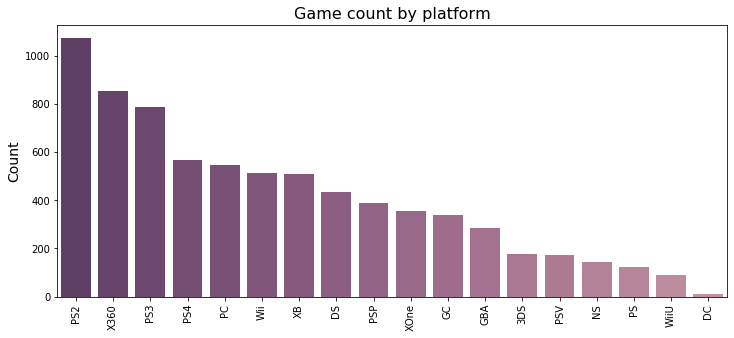

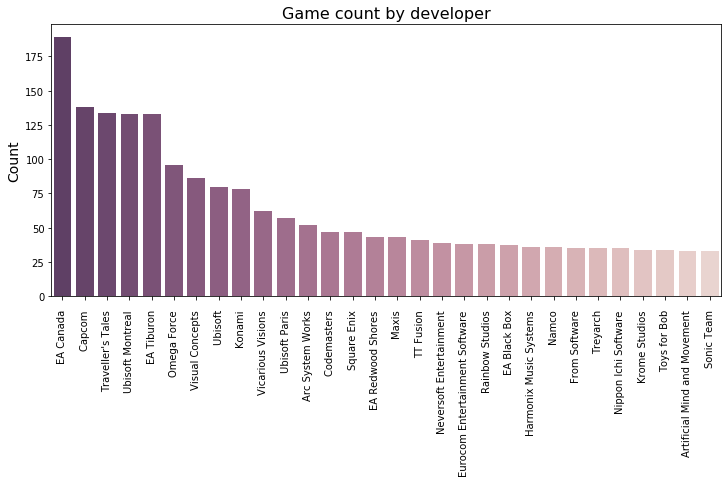

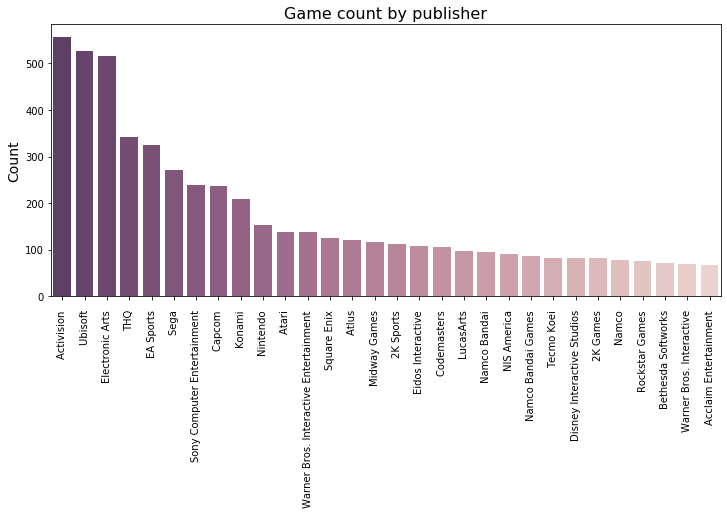

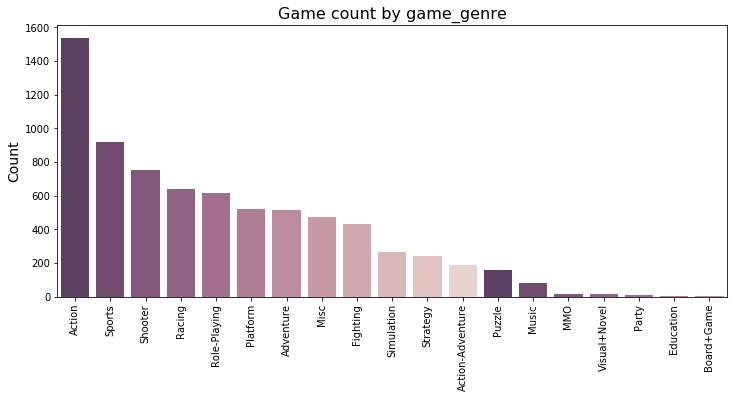

In [61]:
cols = ['platform', 'developer', 'publisher', 'game_genre']

for col in cols:
    chart = sales_df[['name', col]].groupby([col]).count().sort_values('name', ascending=False).reset_index()
    plt.figure(figsize=(12, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'game_genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

## Sales VS Critic Scores

In [62]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [63]:
temp_df2 = sales_df.dropna(subset=['meta_critic_score']).reset_index(drop=True)
temp_df2['score_group'] = temp_df2['meta_critic_score'].apply(lambda x: score_group(x))

In [64]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'platform':
        return 14.4
    elif x == 'developer':
        return 13.2
    elif x == 'publisher':
        return 11.3
    elif x == 'game_genre':
        return 13.6

def height(x):
    if x == 'game_genre':
        return 8
    else:
        return 9

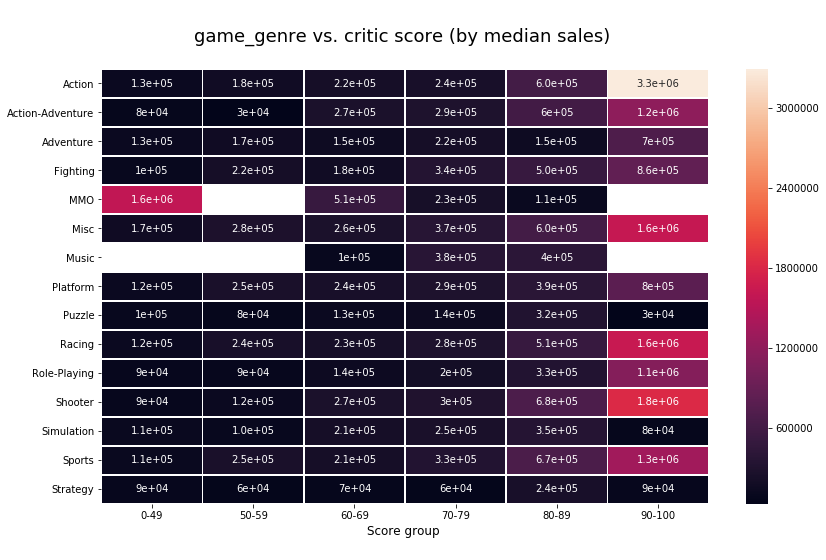

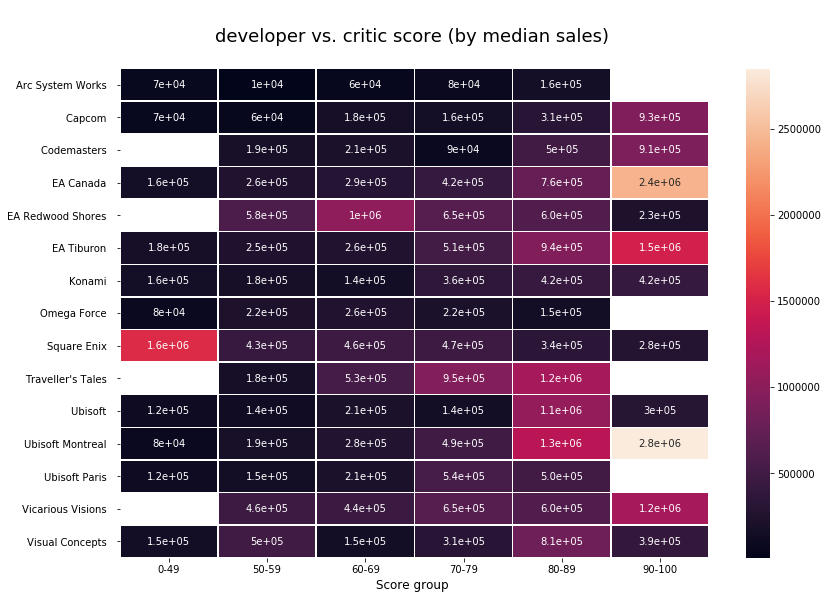

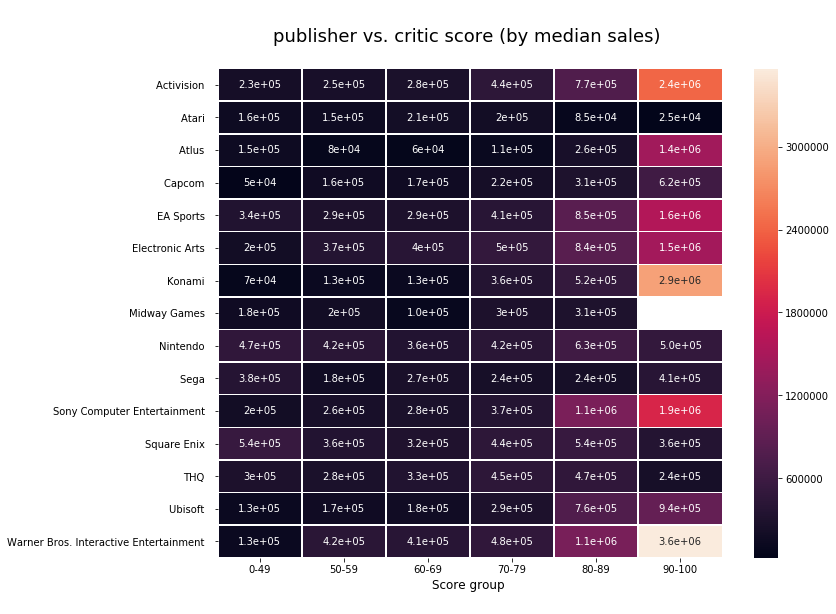

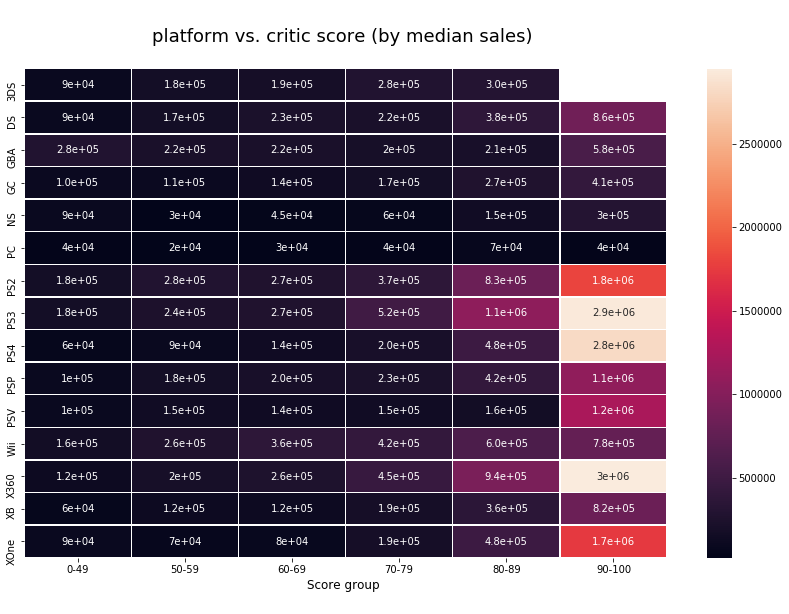

In [65]:
cols = ['game_genre', 'developer', 'publisher','platform' ]
for col in cols:
    pack = []
    top = temp_df2[['name', col]].groupby([col]).count().sort_values('name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    temp_df2[col] =temp_df2[col].apply(lambda x: in_top(x))
    sales_df_platform = temp_df2[[col, 'score_group', 'global_sales']].groupby([col, 'score_group']).median().reset_index().pivot(col, "score_group", "global_sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(sales_df_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

In [66]:
cols = ['platform', 'game_genre', 'publisher', 'developer']
for col in cols:
    uniques = sales_df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        sales_df.loc[sales_df[col] == k, col] = v

In [67]:
sales_df1 = sales_df[['platform','game_genre','publisher','release_year','meta_critic_score','global_sales']]
sales_df1 = sales_df1.dropna().reset_index(drop=True)
sales_df1 = sales_df1.astype('float64')

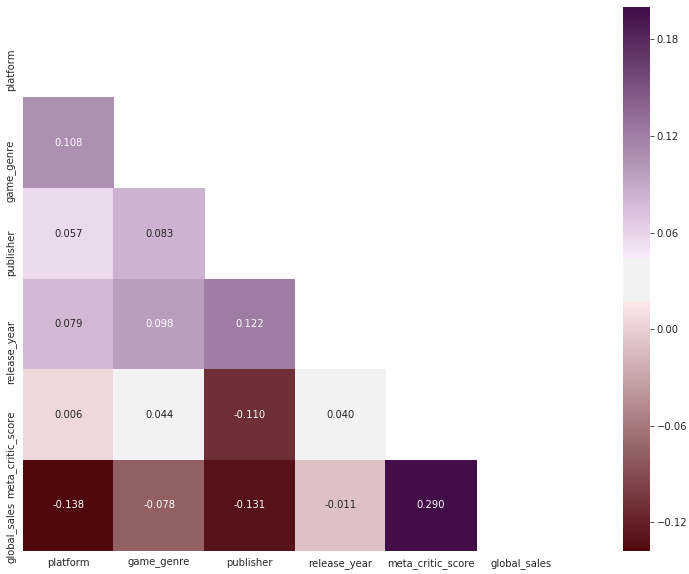

In [68]:
mask = np.zeros_like(sales_df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    ax = sns.heatmap(sales_df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

In [69]:
temp_df3 = temp_df1[['name','platform','game_genre','publisher','release_year','meta_critic_score','global_sales']]
temp_df3 = temp_df3.dropna().reset_index(drop=True)
sales_df2 = temp_df3[['platform','game_genre','publisher','release_year','meta_critic_score','global_sales']]
sales_df2['Hit'] = sales_df2['global_sales']
sales_df2.drop('global_sales', axis=1, inplace=True)

In [70]:
def hit(sales):
    if sales >= 1000000:
        return 1
    else:
        return 0

sales_df2['Hit'] = sales_df2['Hit'].apply(lambda x: hit(x))

In [98]:
sales_df2.to_csv('../data/analysis/Hit.csv')

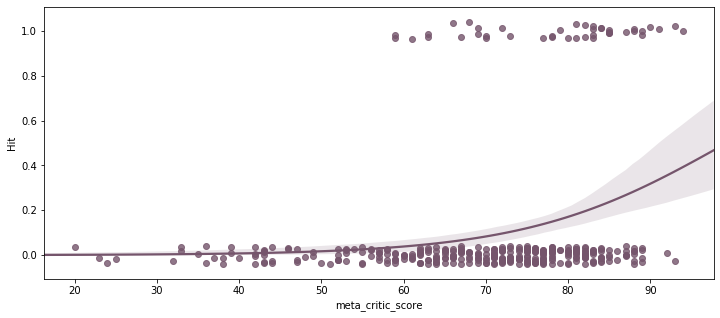

In [94]:
n = ceil(0.05 * len(sales_df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="meta_critic_score", y="Hit", data=sales_df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

<b>It seems hits are mostly found near high critic scores, while non-hits can vary in scores but don't have as strong of a presence in the high score ranges.</b>

In [72]:
from pandas import get_dummies
sales_df_copy = pd.get_dummies(sales_df2)

In [73]:
sales_df_copy[:5]

,release_year,meta_critic_score,Hit,platform_3DS,platform_DC,platform_DS,platform_GBA,platform_GC,platform_NS,platform_PC,...,publisher_Wolfgame,publisher_Working Designs,publisher_XS Games,publisher_Xicat Interactive,publisher_Xseed Games,publisher_Yuke's,publisher_Zoo Digital Publishing,publisher_Zoo Games,publisher_bitComposer Games,publisher_inXile Entertainment
0,2013,97,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014,97,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2002,95,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013,97,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,98,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
sales_df3 = sales_df_copy
y = sales_df3['Hit'].values
sales_df3 = sales_df3.drop(['Hit'],axis=1)
X = sales_df3.values

In [75]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

In [76]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

C:\Users\Sean Harkin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation accuracy:  0.875237320314619


In [77]:
log_reg = LogisticRegression().fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.8801193382153513


C:\Users\Sean Harkin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3161
           1       0.70      0.28      0.40       526

    accuracy                           0.88      3687
   macro avg       0.79      0.63      0.67      3687
weighted avg       0.86      0.88      0.86      3687



Text(0.5, 1, 'Training Set Confusion Matrix')

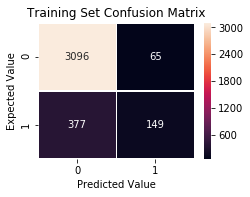

In [79]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
ax.set_title("Training Set Confusion Matrix")

In [80]:
indices = np.argsort(radm.feature_importances_)[::-1]
print('Feature ranking (top 10):')
for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], sales_df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking (top 10):
1. feature 1 meta_critic_score (0.269961)
2. feature 0 release_year (0.162901)
3. feature 11 platform_PS3 (0.026125)
4. feature 20 game_genre_Action (0.022740)
5. feature 10 platform_PS2 (0.018651)
6. feature 252 publisher_Rockstar Games   (0.018604)
7. feature 34 game_genre_Shooter (0.017877)
8. feature 32 game_genre_Racing (0.017807)
9. feature 105 publisher_Electronic Arts   (0.017512)
10. feature 17 platform_X360 (0.016537)


In [81]:
not_hit_copy = sales_df_copy[sales_df_copy['Hit'] == 0]

In [82]:
sales_df4 = not_hit_copy
y = sales_df4['Hit'].values
sales_df4 = sales_df4.drop(['Hit'],axis=1)
X = sales_df4.values

In [83]:
pred = log_reg.predict_proba(X)

In [84]:
temp_df3 = temp_df3[temp_df3['global_sales'] < 1000000]

In [85]:
temp_df3['Hit_Probability'] = pred[:,1]

In [86]:
temp_df3.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
temp_df3 = temp_df3[['name', 'platform', 'Hit_Probability']]

In [97]:
temp_df3.to_csv('../data/analysis/Hit_prediction.csv')

### Top 10 games with highest probability of becoming hits

In [87]:
temp_df3[:10].reset_index(drop=True)

,name,platform,Hit_Probability
0,LEGO The Lord of the Rings,Wii,0.817741
1,Star Wars: Jedi Starfighter,PS2,0.792766
2,Secret Weapons Over Normandy,PS2,0.792009
3,Bully,PS2,0.790060
4,Rock Band 3,Wii,0.783620
5,Burnout Revenge,PS2,0.780233
6,Rock Band 3,PS3,0.766387
7,Rock Band 3,X360,0.762478
8,The Warriors,PS2,0.745554
9,Bully: Scholarship Edition,Wii,0.740243


### Top 10 games  with lowest probability of becoming hits

In [88]:
temp_df3[:-11:-1].reset_index(drop=True)

,name,platform,Hit_Probability
0,Leisure Suit Larry: Box Office Bust,PC,0.000054
1,Tokyo Tattoo Girls,PSV,0.000175
2,Aquaman: Battle for Atlantis,GC,0.000193
3,Langrisser: Re:Incarnation Tensei,3DS,0.000222
4,Terraria,WiiU,0.000223
5,Batman: Dark Tomorrow,GC,0.000285
6,Tenkai Knights: Brave Battle,3DS,0.000294
7,ARK: Survival Evolved,NS,0.000315
8,Nickelodeon Party Blast,XB,0.000316
9,Fist of the North Star: Ken's Rage 2,WiiU,0.000319
